# **Image Classification**
Image classification is the task of assigning a label or class to an image. There are many applications for image classification, such as detecting damage after a natural disaster, monitoring crop health, or helping screen medical images for signs of disease.

We shall create a CNN model and train it using flowers dataset. We shall also use regularization techniques, data augmentation and addition of dropout to the model for combating overfitting.

### **1. Import Required Libraries**

In [ ]:
import PIL
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

### **2. Load Data**

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

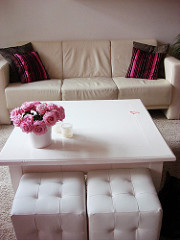

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

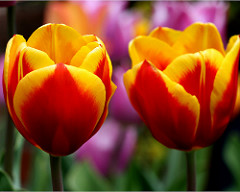

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[1]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset='training',
    seed=44,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset='validation',
    seed=44,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_dataset.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
train_dataset.element_spec

(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Shape of images is  (32, 180, 180, 3)
Shape of labels is  (32,)


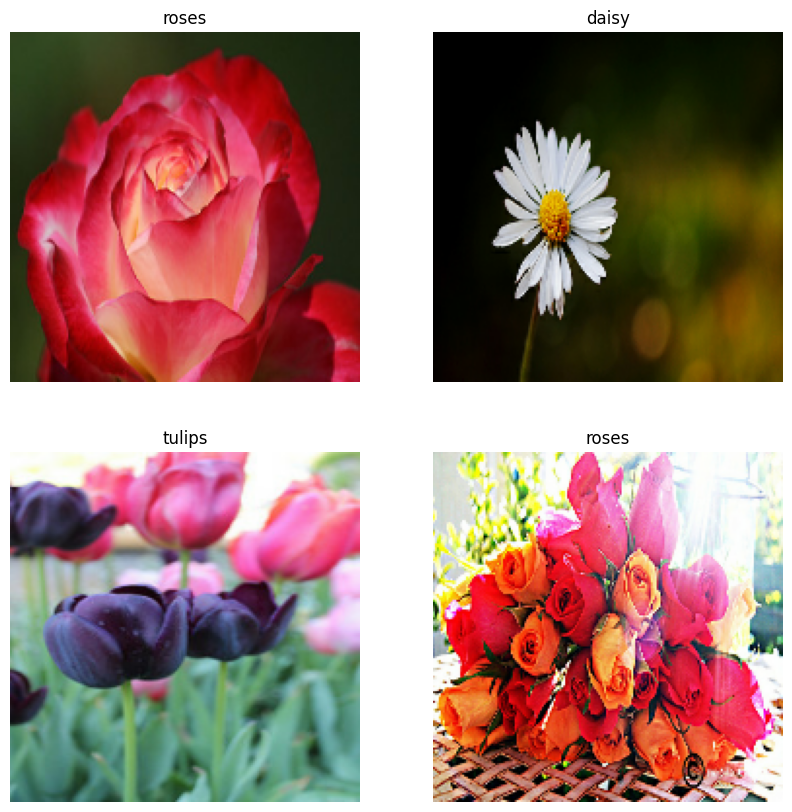

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.skip(5).take(1):
  print('Shape of images is ', images.shape)
  print('Shape of labels is ', labels.shape)
  for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.imshow(images[idx].numpy().astype('uint8'))
    plt.title(class_names[labels[idx]])
    plt.axis('off')

### **3. Preprocess Data**

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1.0/255)

normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
images_batch, labels_batch = next(iter(normalized_train_dataset))
first_image = images_batch[0]
print(f"{np.min(first_image)}, {np.max(first_image)}")

0.0, 1.0


### **4. Create Model**

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomCrop(img_height, img_width)
])

In [ ]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(num_classes)
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

### **5. Train the Model**

In [ ]:
num_epochs = 10

normalized_train_dataset = normalized_train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
normalized_validation_dataset = normalized_validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(normalized_train_dataset, validation_data=normalized_validation_dataset, epochs=num_epochs, verbose=1)

Epoch 1/10
92/92 [==============================] - 24s 83ms/step - loss: 1.3915 - accuracy: 0.4002 - val_loss: 1.1294 - val_accuracy: 0.5450
Epoch 2/10
92/92 [==============================] - 3s 31ms/step - loss: 1.0817 - accuracy: 0.5603 - val_loss: 1.0750 - val_accuracy: 0.5531
Epoch 3/10
92/92 [==============================] - 3s 31ms/step - loss: 0.9932 - accuracy: 0.6100 - val_loss: 0.9932 - val_accuracy: 0.5995
Epoch 4/10
92/92 [==============================] - 3s 33ms/step - loss: 0.9042 - accuracy: 0.6543 - val_loss: 0.9810 - val_accuracy: 0.6253
Epoch 5/10
92/92 [==============================] - 3s 31ms/step - loss: 0.8611 - accuracy: 0.6723 - val_loss: 0.9026 - val_accuracy: 0.6553
Epoch 6/10
92/92 [==============================] - 3s 32ms/step - loss: 0.7995 - accuracy: 0.6873 - val_loss: 0.9146 - val_accuracy: 0.6403
Epoch 7/10
92/92 [==============================] - 3s 33ms/step - loss: 0.7647 - accuracy: 0.7098 - val_loss: 0.8480 - val_accuracy: 0.6771
Epoch 8/10
9

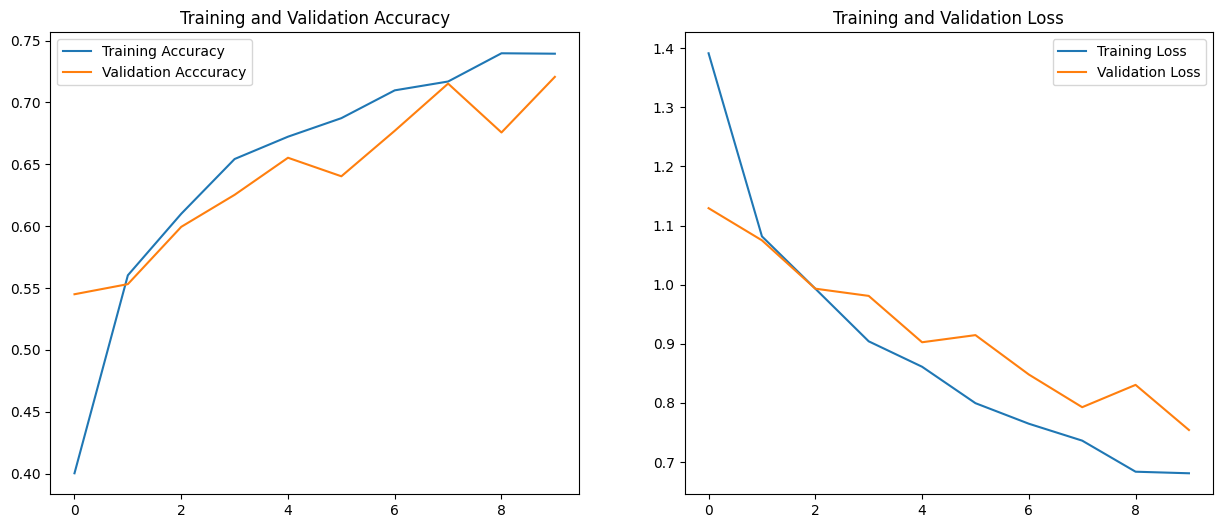

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), accuracy, label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy, label='Validation Acccuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()